# Handling large images with RDM

Here we use patchwise RDM to ring deconvolve large images quickly without too much memory cost

The data we use in this notebook is from the Minoscope and multicolor fluorescence system.


## Setup

Here we import some necessary packages/helper functions

In [14]:
%load_ext autoreload
%autoreload 2
!export CUDA_VISIBLE_DEVICES=0,1,2,3 # REPLACE this line according to your GPUs

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3" # REPLACE this line according to your GPUs

import sys
sys.path.append("..") # since the package is one level above. Normally you should keep them on the same!
import rdmpy

# here are some basics we will need for the demo
import torch
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize
from PIL import Image

# REPLACE this in according to your computer, we highly recommend using a GPU.
# We needed ~20GB of GPU memory to run at full resolution (1024 x 1024).
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
    
print('Using ' +str(device) + ' for computation')

def center_crop(img, des_shape, center=None):
    if center is None:
        center = (img.shape[0] // 2, img.shape[1] // 2)
    left, right, up, down = (
        center[1] - des_shape[1] // 2,
        center[1] + int(np.round(des_shape[1] / 2)),
        center[0] - des_shape[0] // 2,
        center[0] + int(np.round(des_shape[0] / 2)),
    )
    img = img[up:down, left:right]
    return img

def crop(img, c):
    return img[c:-c,c:-c]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cuda:0 for computation


In [ ]:
base_dir = '' #if you decide to set the rdm data outside the package, set the path here.

## Miniscope

Make sure to download the miniscope data for the next few cels

In [16]:
dim = 1920 # Large image size!
center = (967, 1160) # manually calibrated
CROP=38
patch_size=32 # Set based on memory/speed needs. 0 will be full ring deconv but will be more memory intensive. 
# Can go all the way down to dim (which would be regular deconvolution)

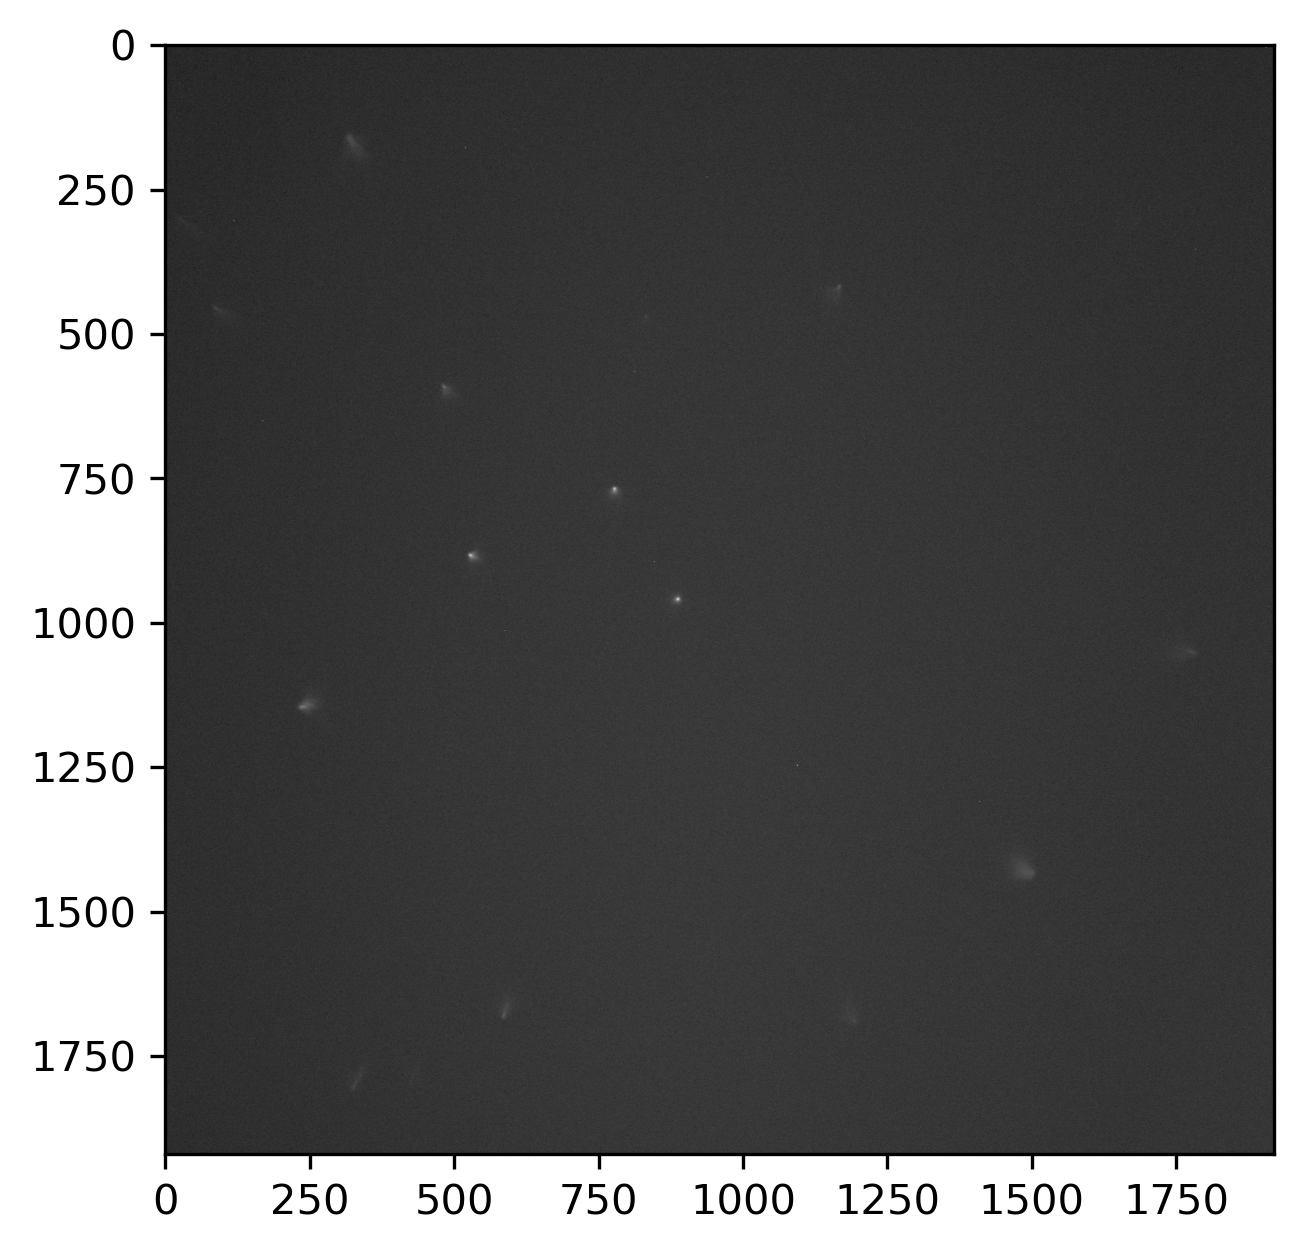

In [17]:
calibration_image = np.array(Image.open(base_dir+'rdm_data/miniscope/calibration/1.tif')) -  np.array(Image.open(base_dir+'rdm_data/miniscope/calibration/background.tif'))
plt.imshow(center_crop(calibration_image**(1/2), [dim,dim]), cmap='gray')
plt.show()

This next cell will take a bit of time and consume some memory, especially at the full resolution

[ 971 1223]
fitting seidel coefficients...


100%|██████████| 500/500 [02:07<00:00,  3.91it/s]


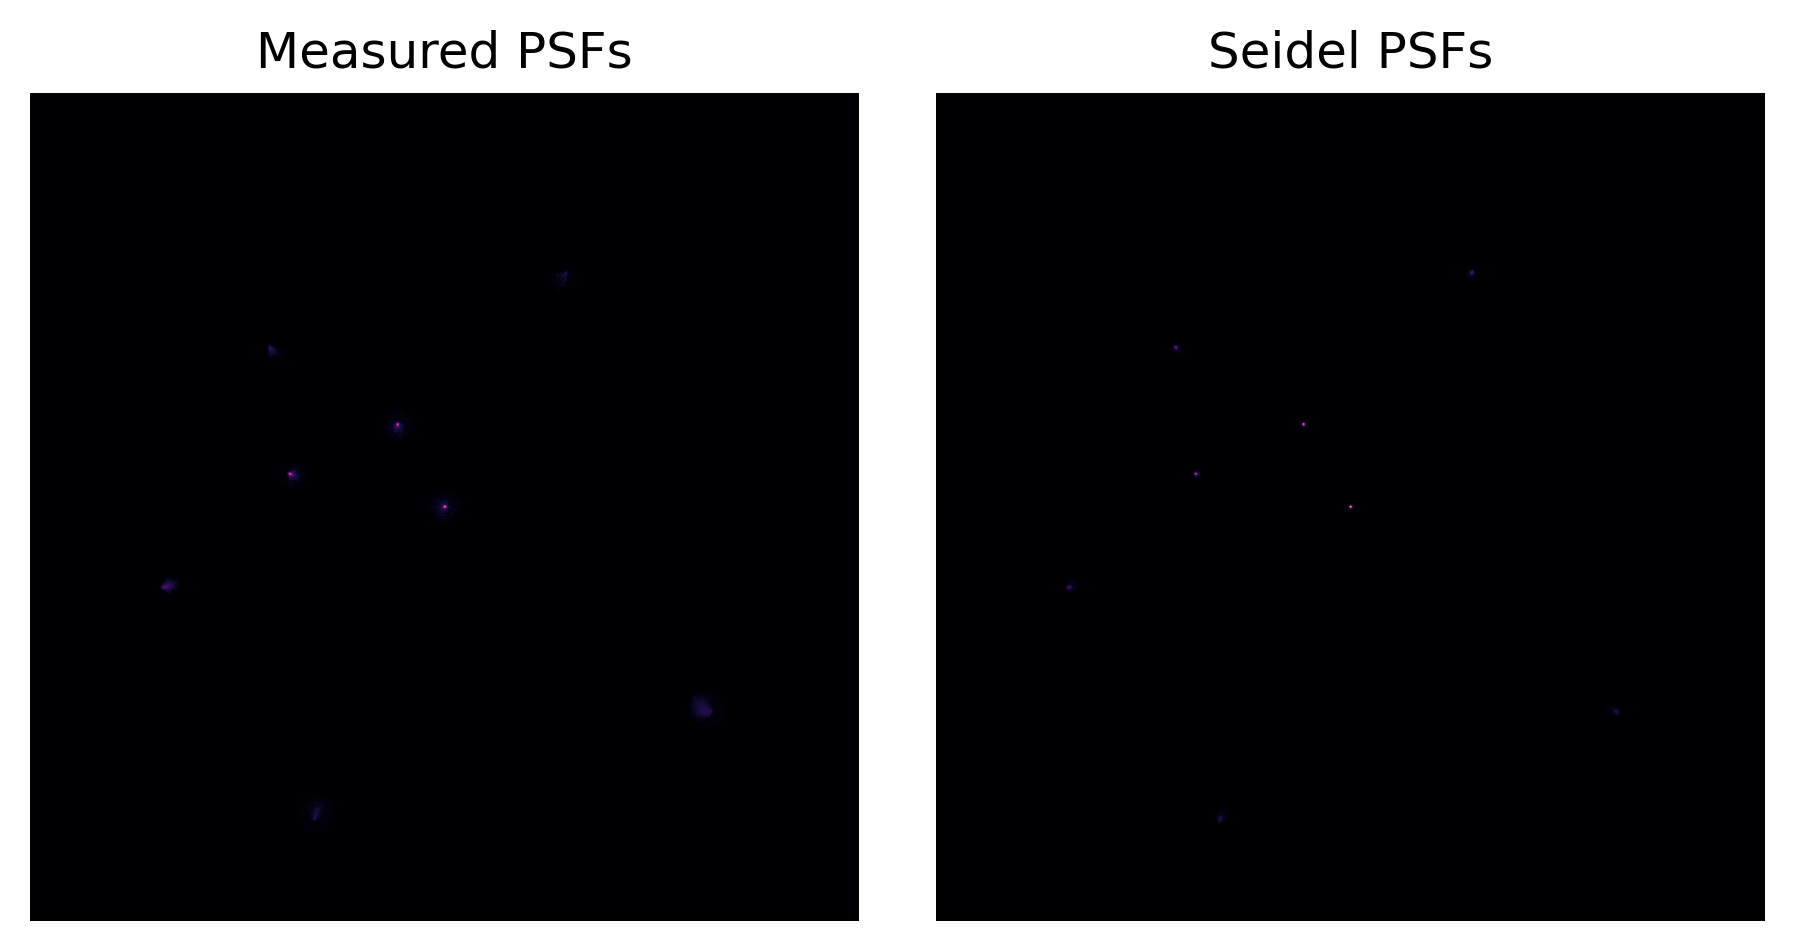

Fitted seidel coefficients: tensor([[0.7376],
        [0.7785],
        [1.1664],
        [1.2517],
        [0.0000],
        [0.0000]])
rendering PSFs...


100%|██████████| 60/60 [00:00<00:00, 439.34it/s]


In [18]:
fit_params = {"centered_psf": True, "iters": 500, "num_seidel": 4, "lr": 1e-2}
seidel_coeffs, psf_data = rdmpy.calibrate_rdm(calibration_image, dim=dim, fit_params=fit_params, device=device, show_psfs=True, patch_size=patch_size)

## Deblurring waterbears
As seen in the miniscope notebook we can ring deconvolve images of waterbears. But now, using patchwise ring deconv, we are able to handle a much bigger image crop.

  0%|          | 0/200 [00:00<?, ?it/s]/home/amit/micromamba/envs/psf/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/amit/micromamba/envs/psf/lib/python3.12/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


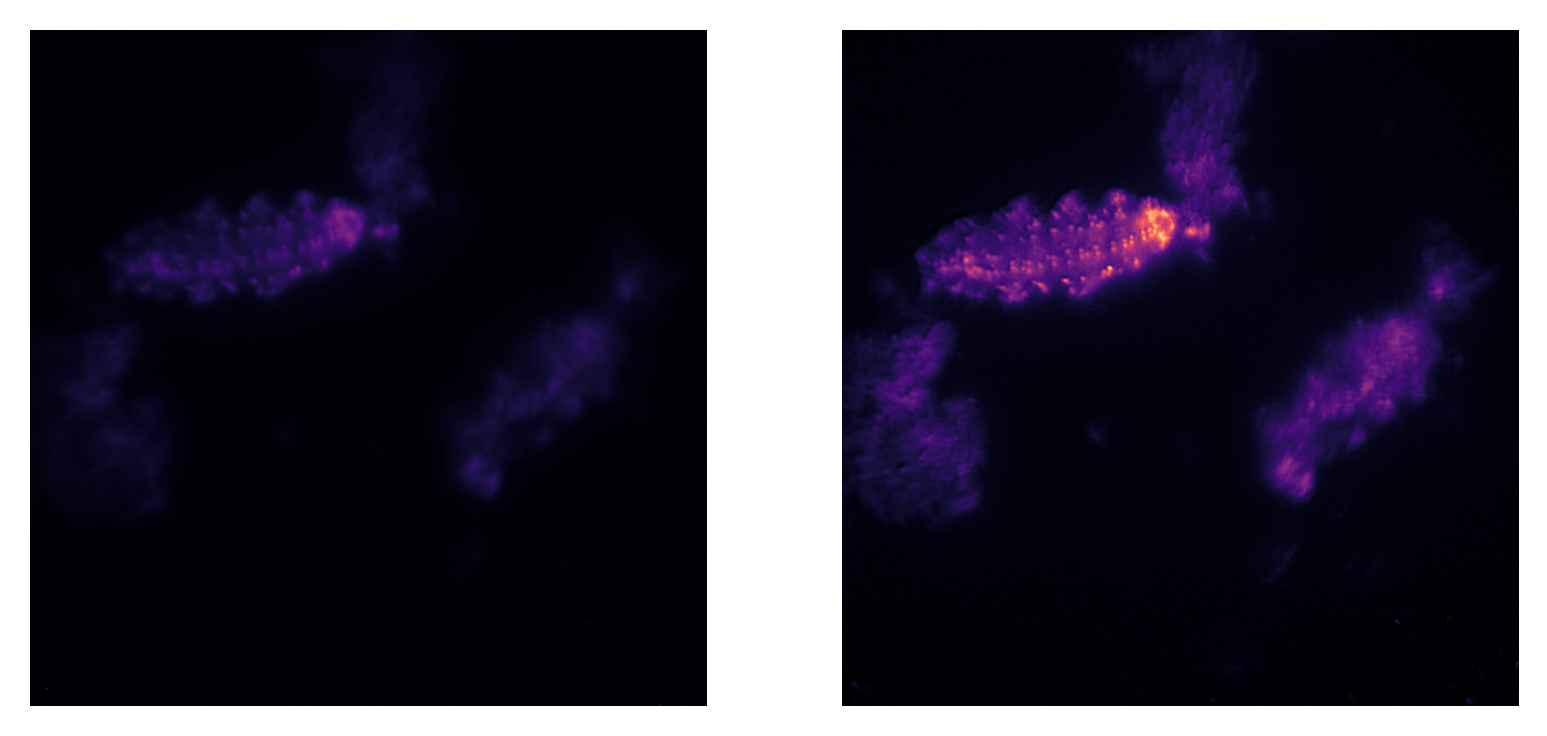

In [19]:
# read in a waterbear
wb1 = center_crop(np.load(base_dir+'rdm_data/miniscope/waterbear/12.npy') - np.load(base_dir+'rdm_data/miniscope/waterbear/background.npy'), (dim,dim), center=center)
wb1_rd = rdmpy.ring_deconvolve(
    wb1,
    psf_data,
    process= True,
    hot_pixel=True, # rdmpy also features a hot pixel remover!
    patch_size=patch_size,
    opt_params={
        "lr": 5e-2,
        "iters": 200,
        "tv_reg": 6e-11,
        "l2_reg": 1e-6,
        "l1_reg": 0,
        "upper_projection": True
    },
    device=device,
)

# plot raw and ring deconvolved beads
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(crop(rdmpy._src.util.process(wb1, wb1.shape, hot_pix=True),CROP), cmap='magma')
ax1.axis('off')
ax2.imshow(crop(wb1_rd,CROP), cmap='magma')
ax2.axis('off') 
plt.show()

We can repeat this for rabbit liver tissue

100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


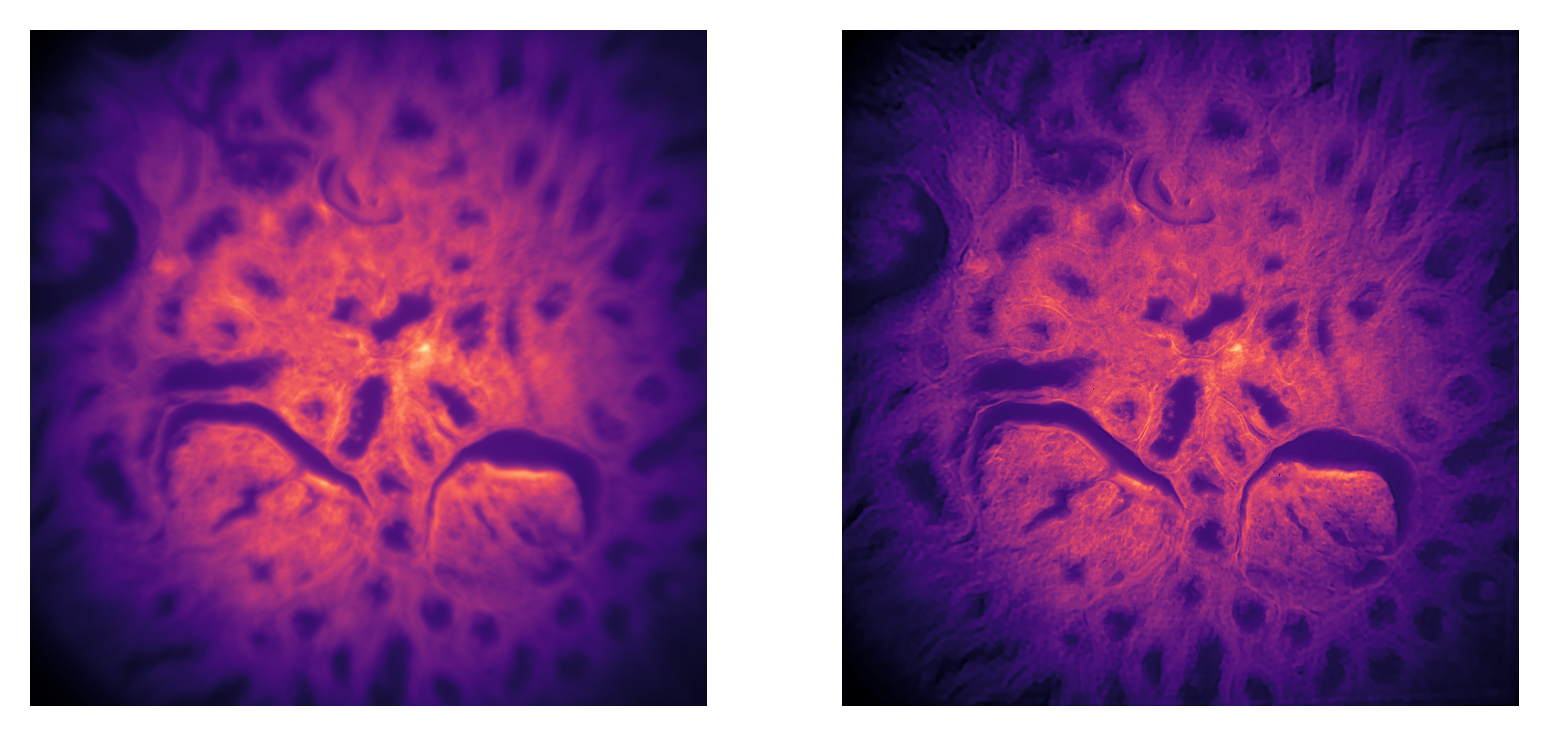

In [20]:
# read in a sample
rl1 = center_crop(np.load(base_dir+'rdm_data/miniscope/rabbitliver/1.npy') - np.load(base_dir+'rdm_data/miniscope/rabbitliver/background.npy'), (dim,dim), center=center)
rl1_rd = rdmpy.ring_deconvolve(
    rl1,
    psf_data,
    process=True,
    patch_size=patch_size,
    opt_params={
        "lr": 5e-2,
        "iters": 200,
        "tv_reg": 1e-10,
        "l2_reg": 1e-9,
        "l1_reg": 0,
        "upper_projection": True,
    },
    device=device,
)


# plot raw and ring deconvolved beads
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(crop(rl1,CROP), cmap='magma')
ax1.axis('off')
ax2.imshow(crop(rl1_rd,CROP), cmap='magma')
ax2.axis('off') 
plt.show()

## Large multicolor fluorescent images
In the multicolor notebook we ring deconvolved multicolor fluorescent images. But because the images were so large we had to downsample them. Now, using patchwise ring deconvolution, we no longer need to! 

Make sure you have the multicolor downloaded for this part.

In [21]:
GREEN = 518e-9
RED = RED = 650e-9
dim = 2040 # Pick this according to how big of an image you want to deblur. Reduce if memory errors.
center = [1022, 1024] 
patch_size=24 # Set based on memory/speed needs. 0 will be full ring deconv but will be more memory intensive.

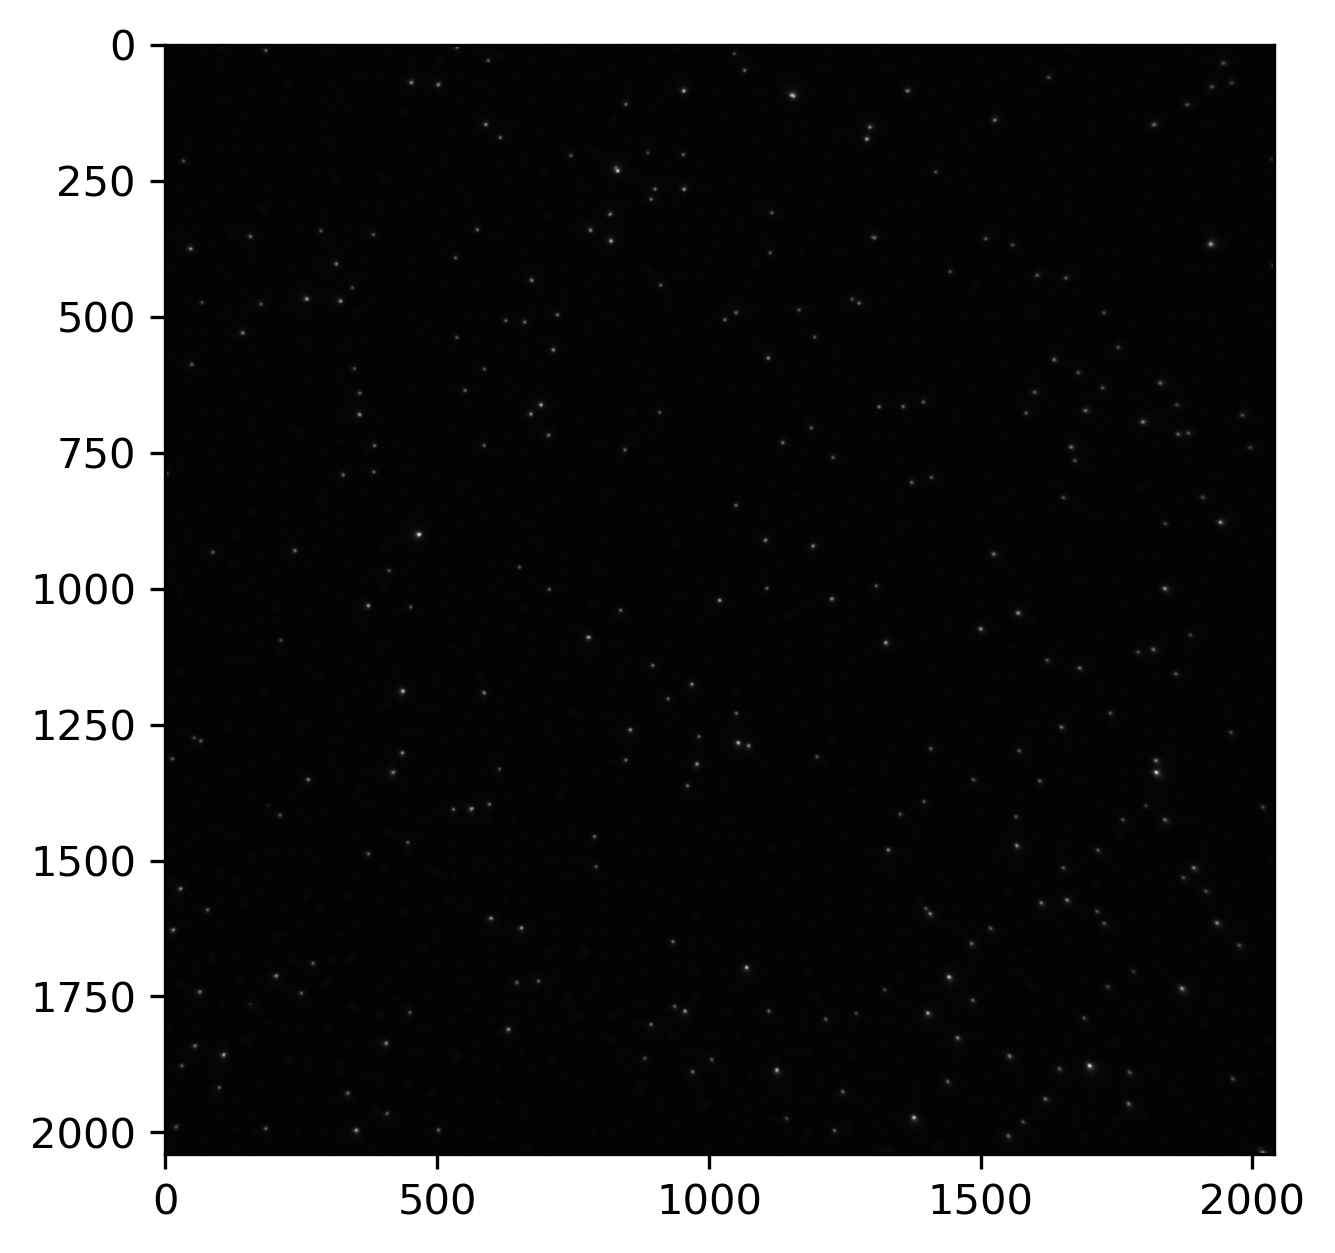

In [23]:
calib_img_r = np.array(Image.open(base_dir+'rdm_data/multicolor/0.1_um_red_beads/0.1_um_red_beads_004.tif'))

plt.imshow(center_crop(calib_img_r**(1/2), [dim,dim]), cmap='gray')
plt.show()

fitting seidel coefficients...


100%|██████████| 100/100 [01:06<00:00,  1.49it/s]


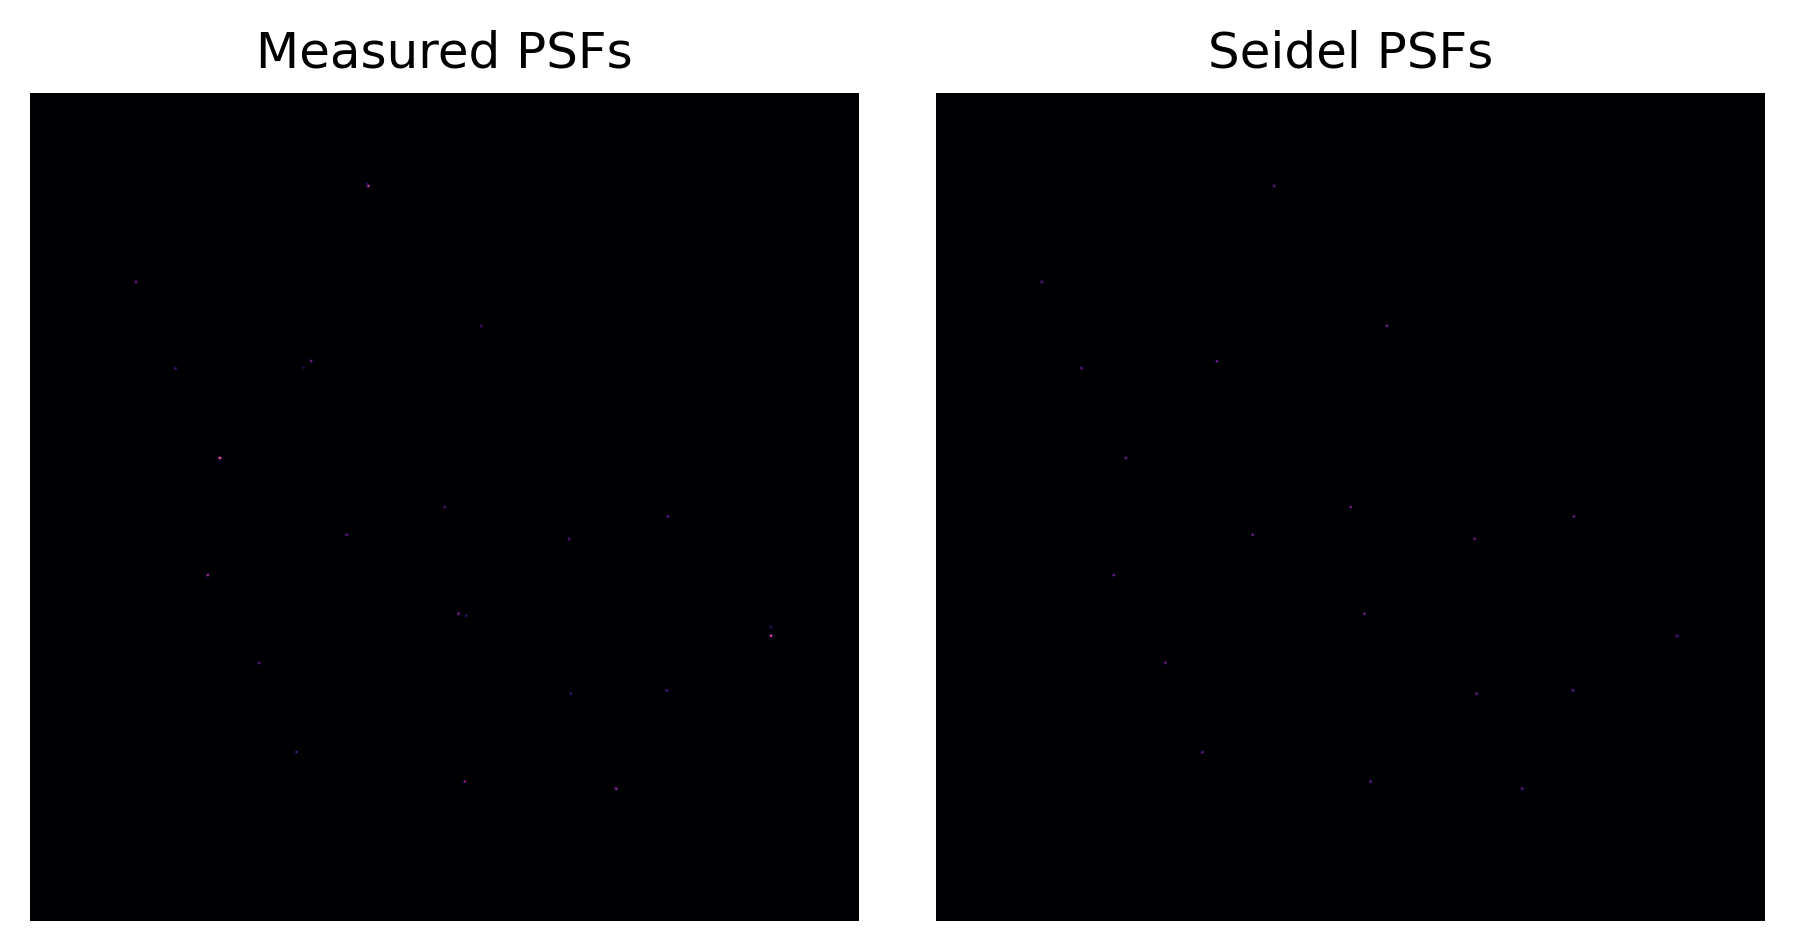

Fitted seidel coefficients: tensor([[0.4683],
        [0.2072],
        [0.1039],
        [0.1744],
        [0.0000],
        [0.0000]])


In [24]:
fit_params={"sys_center": center, "iters": 100, "threshold": 0.2, "disk": 1, "lr": 7e-2, "min_distance": 200}
sys_params={"lamb" : RED}
seidel_coeffs_r = rdmpy.calibrate_rdm(calib_img_r, dim=dim, device=device, show_psfs=True, fit_params=fit_params, get_psfs=False, sys_params=sys_params)

fitting seidel coefficients...


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


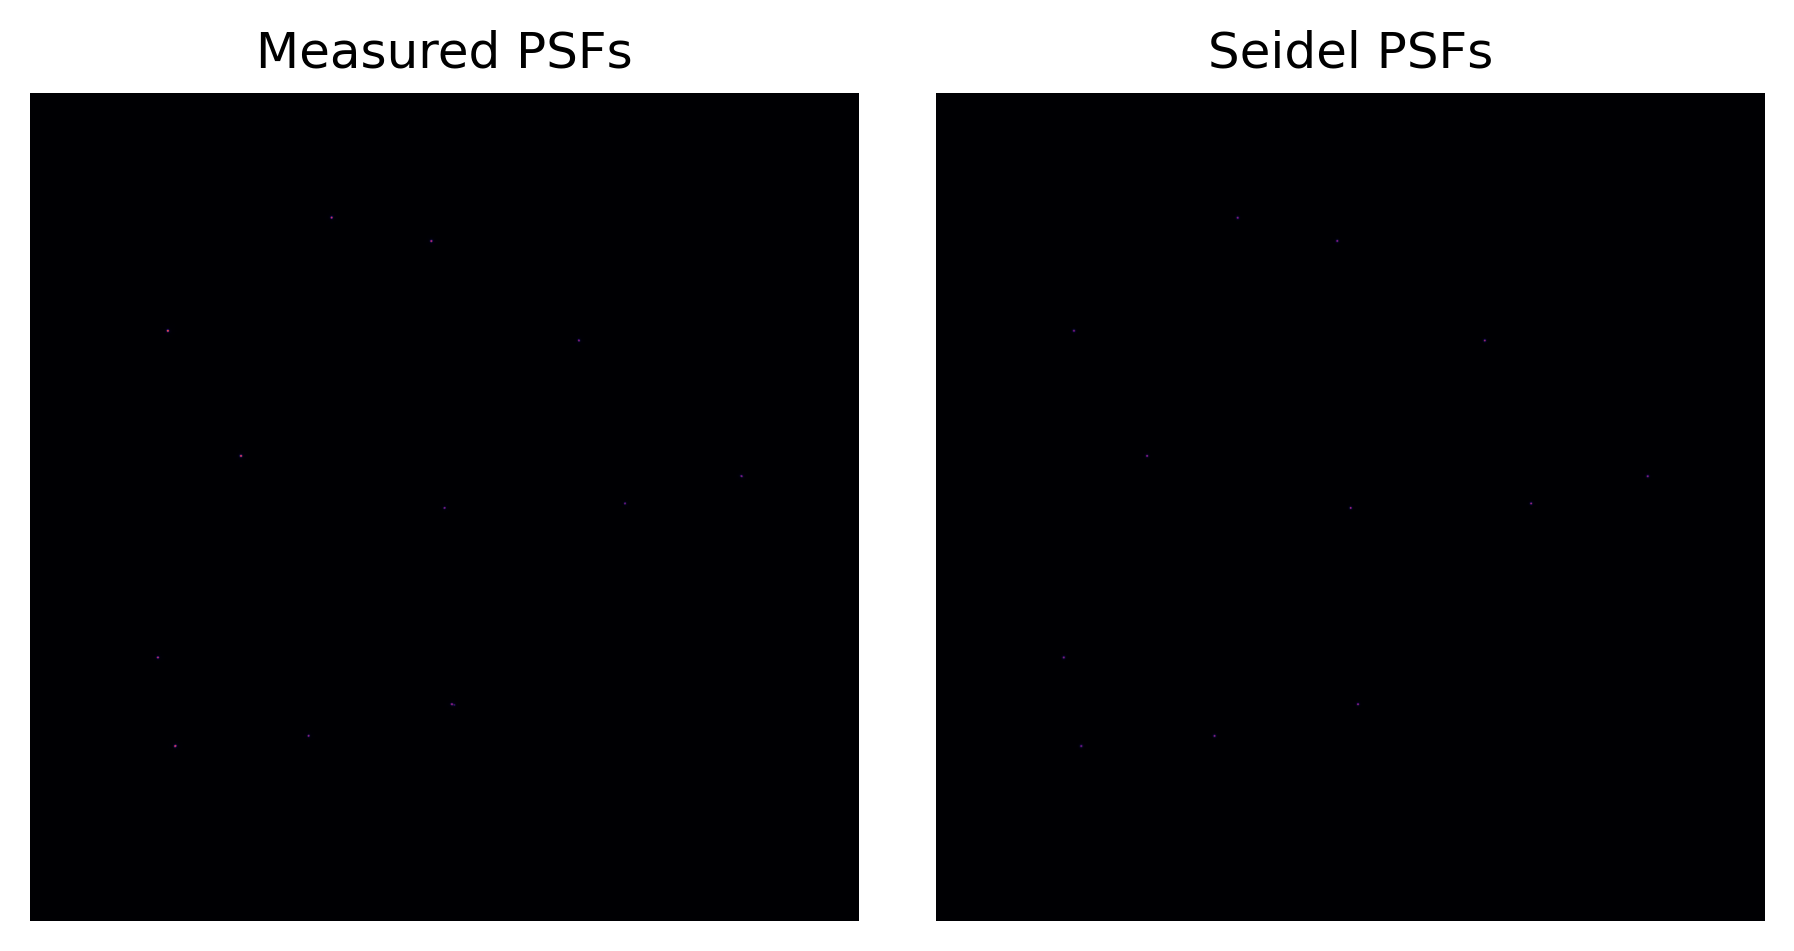

Fitted seidel coefficients: tensor([[0.5260],
        [0.0021],
        [0.0189],
        [0.1664],
        [0.0000],
        [0.0000]])


In [26]:
calib_img_g = np.array(Image.open(base_dir+'rdm_data/multicolor/0.1_um_green_beads/0.1_um_green_beads_004.tif'))
sys_params = {"lamb" : GREEN}
fit_params={"sys_center": center, "iters": 100, "threshold": 0.2, "disk": 1, "lr": 7e-2, "min_distance": 200}
seidel_coeffs_g = rdmpy.calibrate_rdm(calib_img_g, dim=dim, device=device, show_psfs=True, fit_params=fit_params, get_psfs=False, sys_params=sys_params)

In [27]:
bpae = io.imread(base_dir+'rdm_data/multicolor/100x_1.4NA_BPAE_phalloidin488_mitotrackerRed/100x_1.4NA_BPAE_phalloidin488_mitotrackerRed_000.tif')
bpae_r = bpae[1]
bpae_g = bpae[0]

bpae_r = center_crop(bpae_r, [dim,dim], center=center)
bpae_g = center_crop(bpae_g, [dim,dim], center=center)


In [28]:
sys_params = {"lamb" : RED}
psf_data_r = rdmpy.get_rdm_psfs(seidel_coeffs_r, dim=dim, patch_size=patch_size, model='lri', sys_params=sys_params, device=device)

rendering PSFs...


100%|██████████| 85/85 [00:00<00:00, 378.52it/s]


  0%|          | 0/200 [00:00<?, ?it/s]/home/amit/micromamba/envs/psf/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/amit/micromamba/envs/psf/lib/python3.12/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
100%|██████████| 200/200 [03:57<00:00,  1.19s/it]


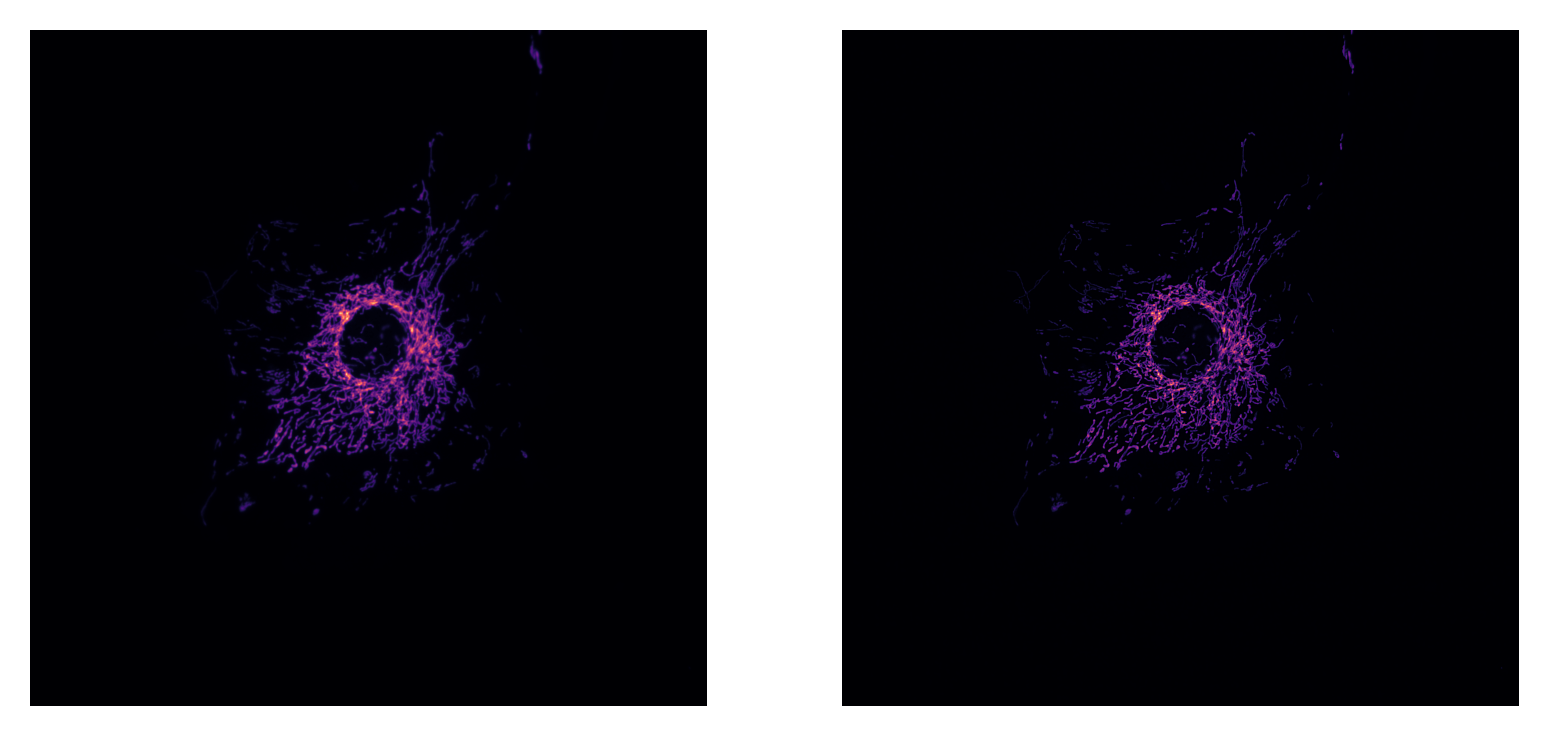

In [29]:
c = 10
torch.cuda.empty_cache()
bpae_recon_r = rdmpy.ring_deconvolve(
    bpae_r,
    psf_data_r,
    process=True,
    patch_size=patch_size,
    opt_params={
        "lr": 5e-2,
        "iters": 200,
        "tv_reg": 1e-10,
        "l2_reg": 1e-9,
        "l1_reg": 0,
        "fraction": 4,
    },
    device=device,
)
bpae_recon_r = bpae_recon_r/bpae_recon_r.max()

# plot raw and ring deconvolved beads
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(crop(bpae_r,c), cmap='magma')
ax1.axis('off')
ax2.imshow(crop(bpae_recon_r,c), cmap='magma')
ax2.axis('off') 
plt.show()

In [30]:
del psf_data_r
sys_params = {"lamb" : GREEN}
psf_data_g = rdmpy.get_rdm_psfs(seidel_coeffs_g, dim=dim, model='lri', patch_size=patch_size, sys_params=sys_params, device=device)

rendering PSFs...


 54%|█████▍    | 46/85 [00:00<00:00, 457.69it/s]

100%|██████████| 85/85 [00:00<00:00, 377.47it/s]


100%|██████████| 200/200 [03:58<00:00,  1.19s/it]


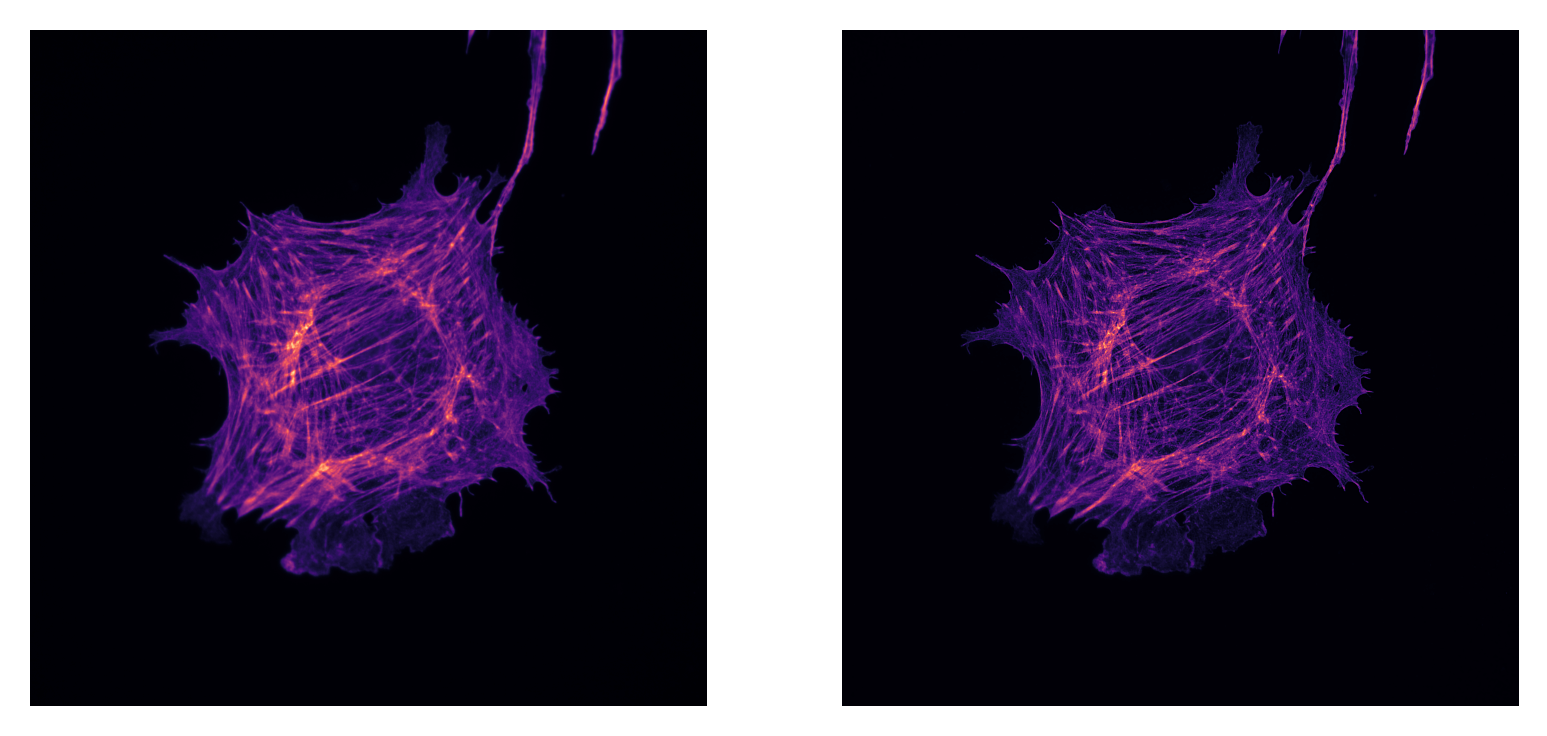

In [31]:
torch.cuda.empty_cache()
bpae_recon_g = rdmpy.ring_deconvolve(
    bpae_g,
    psf_data_g,
    process=True,
    patch_size=patch_size,
    opt_params={
        "lr": 5e-2,
        "iters": 200,
        "tv_reg": 1e-10,
        "l2_reg": 1e-9,
        "l1_reg": 0,
    },
    device=device,
)
bpae_recon_g = bpae_recon_g/bpae_recon_g.max()

# plot raw and ring deconvolved beads
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(crop(bpae_g,c), cmap='magma')
ax1.axis('off')
ax2.imshow(crop(bpae_recon_g,c), cmap='magma')
ax2.axis('off') 
plt.show()

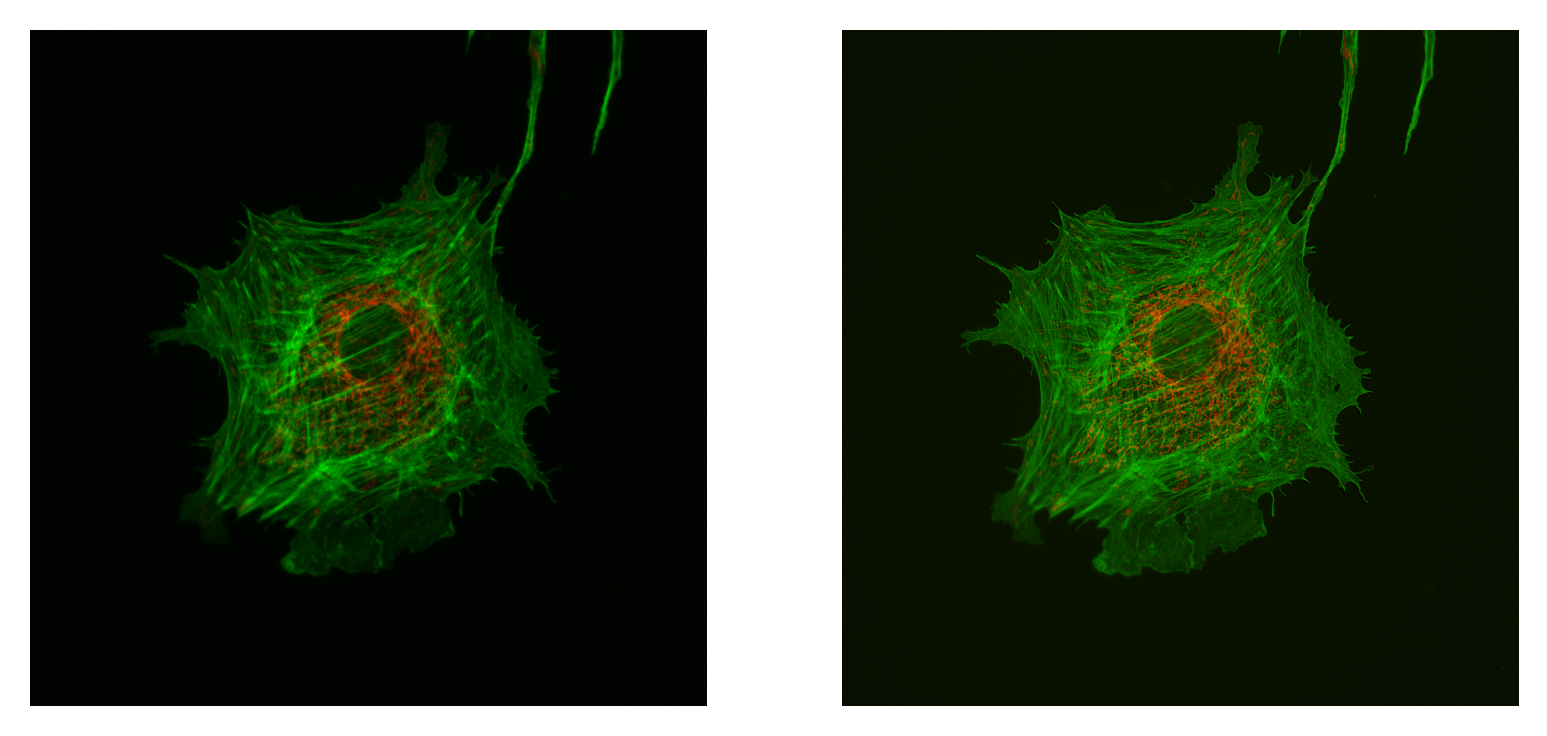

In [33]:
bpae_raw = np.stack(
        [bpae_r/bpae_r.max(), bpae_g/bpae_g.max(), np.zeros_like(bpae_r)], axis=2
)
bpae_recon = np.stack(
        [bpae_recon_r, bpae_recon_g, np.zeros_like(bpae_recon_r)], axis=2
)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(crop(bpae_raw,c))
ax1.axis('off')
ax2.imshow(crop(bpae_recon**0.6,c)) # mild contrast stretch bc of background reduction
ax2.axis('off') 
plt.show()